In [67]:
!pip install xgboost

In [12]:
#!pip install shap

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack, csr_matrix     # Feature Combination
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import shap    # Model Explainability
import joblib      # Model Persistence
import warnings
warnings.filterwarnings("ignore")


In [97]:
df=pd.read_csv("final_dataframe2.csv")

In [98]:
df.head()

,company_id,company_name,job_id,role_title,description,skills_desc,experience_level,max_salary,min_salary,med_salary,...,remote_allowed,datetime,views,applies,sponsored,annual_salary,min_salary_usd,max_salary_usd,avg_salary_monthly_usd,monthly_salary_usd
0,64896719.0,The National Exemplar,10998357,Assitant Restaurant Manager,The National Exemplar is accepting application...,We are currently accepting resumes for FOH - A...,NaN,65000.0,45000.0,NaN,...,NaN,2024-04-16 14:26:54,8.0,NaN,0,55000.0,45000.0,65000.0,4583.333333,4583.333333
1,766262.0,"Abrams Fensterman, LLP",23221523,Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,This position requires a baseline understandin...,NaN,175000.0,140000.0,NaN,...,NaN,2024-04-12 04:23:32,16.0,NaN,0,157500.0,140000.0,175000.0,13125.000000,13125.000000
2,81942316.0,Raw Cereal,103254301,Producer,Company DescriptionRaw Cereal is a creative de...,NaN,NaN,300000.0,60000.0,NaN,...,Yes,2024-04-11 18:43:39,7.0,1.0,0,180000.0,60000.0,300000.0,15000.000000,15000.000000
3,8577252.0,Revesco Properties,266566927,Marketing & Office Coordinator,About Revesco Properties:Revesco Properties is...,NaN,NaN,75000.0,55000.0,NaN,...,NaN,2024-04-18 16:49:28,13.0,1.0,0,65000.0,55000.0,75000.0,5416.666667,5416.666667
4,99212509.0,Recruitment Design,266825034,Software Support Specialist,Are you driven by the thrill of solving proble...,NaN,NaN,65000.0,60000.0,NaN,...,NaN,2024-04-11 18:22:10,NaN,NaN,0,62500.0,60000.0,65000.0,5208.333333,5208.333333


In [72]:
#Make a modeling dataframe (only required columns)
cols = ["role_title", "skills_desc", "experience_level", "location", "monthly_salary_usd"]
df_model = df[cols].copy()

In [73]:
#Basic cleaning (super important)
# target 
df_model = df_model.dropna(subset=["monthly_salary_usd"])

# fill missing input features
df_model["role_title"] = df_model["role_title"].fillna("")
df_model["skills_desc"] = df_model["skills_desc"].fillna("")
df_model["experience_level"] = df_model["experience_level"].fillna("Unknown")
df_model["location"] = df_model["location"].fillna("Unknown")

# ensuring whether salary is numeric
df_model["monthly_salary_usd"] = pd.to_numeric(df_model["monthly_salary_usd"], errors="coerce")
df_model = df_model.dropna(subset=["monthly_salary_usd"])


In [74]:
df["experience_level"].unique()

array([nan, 'Associate', 'Entry level', 'Mid-Senior level', 'Director',
       'Executive', 'Internship'], dtype=object)

In [75]:
#Convert experience_level → numeric (ordinal)
exp_map = {
    "Internship": 0,
    "Entry_level": 1,
    "Junior": 1,
    "Mid-Senior level": 2,
    "Associate": 2,
    "Lead": 4,
    "Manager": 4,
    "Director": 5,
    "Unknown": -1
}
df_model["exp_encoded"] = df_model["experience_level"].map(exp_map).fillna(-1).astype(int)


In [76]:
#Convert text columns into numeric features (TF-IDF)
role_vec = TfidfVectorizer(max_features=300, ngram_range=(1,2), stop_words="english")
skills_vec = TfidfVectorizer(max_features=600, ngram_range=(1,2), stop_words="english")

X_role = role_vec.fit_transform(df_model["role_title"])
X_skills = skills_vec.fit_transform(df_model["skills_desc"])


In [77]:
#Convert location into numeric 
state_ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
X_state = state_ohe.fit_transform(df_model[["location"]])


In [78]:
#Joins different encoded features into one dataset that the machine learning model uses for training
X_exp = csr_matrix(df_model[["exp_encoded"]].values)

X = hstack([X_role, X_skills, X_state, X_exp]).tocsr()
y = df_model["monthly_salary_usd"].values


In [79]:
#train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20% data kept for testing
    random_state=42     # makes the split reproducible
)


In [80]:
#model
model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)

In [81]:
preds = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, preds))
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE:", rmse)
print("R2:", r2_score(y_test, preds))



MAE: 2334.5603069764675
RMSE: 3479.9438489268473
R2: 0.4133439877191617


In [82]:
#analysing 
df_model.groupby("role_title")["monthly_salary_usd"].mean().sort_values(ascending=False).head(10)
df_model.groupby("location")["monthly_salary_usd"].mean().sort_values(ascending=False).head(10)
df_model.groupby(["role_title","location"])["monthly_salary_usd"].mean().sort_values(ascending=False).head(10)


role_title                                                 location               
Artificial Intelligence Vice President                     New York, NY               33333.333333
Sales Consultant - Owner - Signature Line - $300k-$500k+   Cape Canaveral, FL         33333.333333
Investment Real Estate Sales Advisor                       Dallas, TX                 33333.333333
SVP Physician Operations – Medical Affairs Administration  Brooklyn, NY               33333.333333
iOS Software Engineer 4 - Consumer Engineering             United States              33333.333333
Director of Product, Databases                             San Mateo, CA              32935.000000
Senior Associate (5 - 8+ years)                            Greater Seattle Area       32916.666667
High Frequency Trading | Senior Software Engineer          Austin, TX                 32791.666667
HFT Trading Firm | Senior Software Engineer                Greater Chicago Area       32791.666667
Information Security Engin

#### Visualizing the actual and predicted salary using plotly

In [83]:
test_preds = model.predict(X_test)

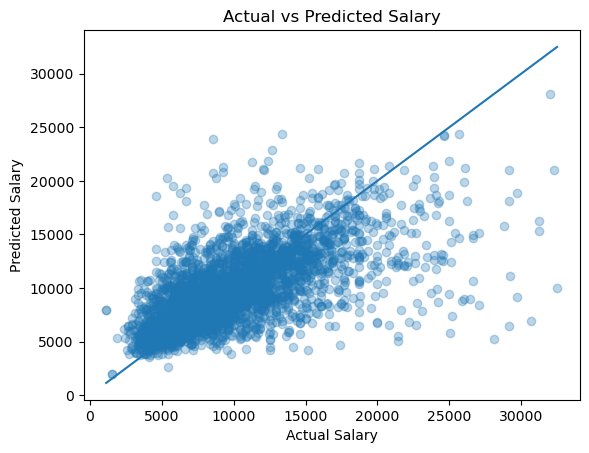

In [84]:
plt.figure()
plt.scatter(y_test, test_preds, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()])
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs Predicted Salary")
plt.show()

In [85]:
#1) do hyperparater tuning and then xgboost regressor , (fisrt check whether we need this or not)
#2) this project is a regression project , so first focus on that  and then additionaly do xgboost classificarion  
# to Predict salary range instead of exact salary i.e salary_band ∈ {Low, Medium, High}.......use this Model type
#RandomForestClassifier   and XGBoostClassifier 
#3) then use postgres to export the df and then do power bi dashboards
#4) push project and documnet it on github
#5) then prepare resume 

### Hyperparameter tuning on current model (Random Forest Regressor)

In [86]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(14722, 3543) (3681, 3543) (14722,) (3681,)


In [87]:
#creating a baseline model to compare
baseline = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

baseline.fit(X_train, y_train)
base_preds = baseline.predict(X_test)

base_r2 = r2_score(y_test, base_preds)
base_rmse = np.sqrt(mean_squared_error(y_test, base_preds))
base_mae = mean_absolute_error(y_test, base_preds)

print("Baseline R2:", base_r2)
print("Baseline RMSE:", base_rmse)
print("Baseline MAE:", base_mae)

Baseline R2: 0.4098672929952134
Baseline RMSE: 3490.240198043554
Baseline MAE: 2343.207828687337


In [88]:
param_dist = {
    "n_estimators": [200, 400, 600, 800, 1000],
    "max_depth": [None, 10, 20, 30, 40, 60],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 8],
    "max_features": ["sqrt", "log2", None]
}

In [89]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=25,          # try 25 first (good balance)
    scoring="r2",
    cv=3,               # 3-fold cross validation
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)

print("Best R2 (CV):", search.best_score_)
print("Best Params:", search.best_params_)
best_rf = search.best_estimator_

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best R2 (CV): 0.4125833152275131
Best Params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 60}


In [90]:
tuned_preds = best_rf.predict(X_test)

tuned_r2 = r2_score(y_test, tuned_preds)
tuned_rmse = np.sqrt(mean_squared_error(y_test, tuned_preds))
tuned_mae = mean_absolute_error(y_test, tuned_preds)

print("Tuned R2:", tuned_r2)
print("Tuned RMSE:", tuned_rmse)
print("Tuned MAE:", tuned_mae)

print("\nImprovement in R2:", tuned_r2 - base_r2)

Tuned R2: 0.42848600883759624
Tuned RMSE: 3434.7403089212526
Tuned MAE: 2384.7618527115255

Improvement in R2: 0.018618715842382838


### Visualizing actual and predicted salary using plotly

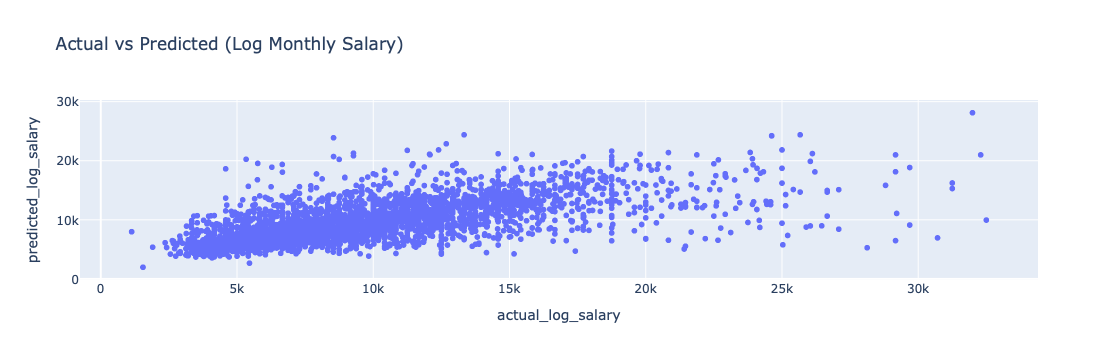

In [91]:
import plotly.express as px
plot_df = pd.DataFrame({
    "actual_log_salary": y_test,
    "predicted_log_salary": preds
})

fig = px.scatter(
    plot_df,
    x="actual_log_salary",
    y="predicted_log_salary",
    title="Actual vs Predicted (Log Monthly Salary)"
)
fig.show()


The model captures the overall salary trend but shows regression-to-the-mean behavior, under-predicting high-salary roles and over-predicting lower-salary roles, indicating scope for feature enrichment and advanced model

#### XGBoost

In [100]:
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [103]:
xgb_preds = xgb.predict(X_test)

In [109]:
xgb_r2 = r2_score(y_test, xgb_preds)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_mae = mean_absolute_error(y_test, xgb_preds)

print("R2:", xgb_r2)
print("RMSE:", xgb_rmse)
print("MAE:", xgb_mae)


R2: 0.4677849329628988
RMSE: 3314.546041816931
MAE: 2367.186175176193


In [105]:
print(type(xgb))
print(type(X_test))

<class 'xgboost.sklearn.XGBRegressor'>
<class 'scipy.sparse._csr.csr_matrix'>


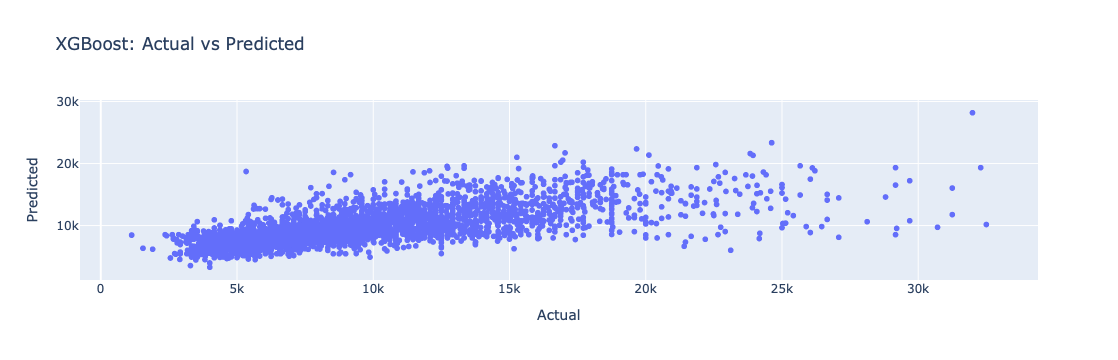

In [110]:
#plotly visualization(xgboost)
plot_df = pd.DataFrame({"Actual": y_test, "Predicted": xgb_preds})
px.scatter(plot_df, x="Actual", y="Predicted", title="XGBoost: Actual vs Predicted").show()

### Hyperparameter Tuning for xgboost

In [111]:
search = RandomizedSearchCV(
    XGBRegressor(objective="reg:squarederror", random_state=42),
    {
        "n_estimators": [300, 500, 800],
        "max_depth": [4, 6, 8],
        "learning_rate": [0.03, 0.05, 0.1]
    },
    n_iter=10,
    cv=3,
    scoring="r2",
    n_jobs=-1
)

search.fit(X_train, y_train)
best_xgb = search.best_estimator_

In [112]:
best_preds = best_xgb.predict(X_test)

from sklearn.metrics import r2_score
print("Tuned XGB R2:", r2_score(y_test, best_preds))

Tuned XGB R2: 0.4866555542167852


In [113]:
# Hyperparameter tuning helped XGBoost learn the salary patterns better, especially for complex feature interactions.

In [115]:
# metrics comparison of 2 models
best_r2 = r2_score(y_test, best_preds)
best_rmse = np.sqrt(mean_squared_error(y_test, best_preds))
best_mae = mean_absolute_error(y_test, best_preds)

In [116]:
metrics_df = pd.DataFrame({
    "Model": ["RandomForest (Tuned)", "XGBoost (Tuned)"],
    "R2": [tuned_r2, best_r2],
    "RMSE": [tuned_rmse, best_rmse],
    "MAE": [tuned_mae, best_mae]
})

metrics_df

,Model,R2,RMSE,MAE
0,RandomForest (Tuned),0.428486,3434.740309,2384.761853
1,XGBoost (Tuned),0.486656,3255.254195,2308.898452


##### We choose XGBoost as the final model because it achieved a higher R² score and lower prediction errors (RMSE and MAE) compared to RandomForest.

In [117]:
#saving the best model
#open with : best_xgb = joblib.load("xgboost_talentsense_model.pkl")

joblib.dump(best_xgb, "xgboost_talentsense_model.pkl")


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


['xgboost_talentsense_model.pkl']